# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Next cell will load the _single agent_ version of the assignment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

brain_name

'ReacherBrain'

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

We will collect `state_size` and `action_size` for later.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)


while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

        
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


# Assignment Starts Here

## Actor

The `Actor` object is a 2-layer dense neural net, where the output layer is modulated by a `tanh` non linearity. We use `tanh` to generate a continout output `[-1, 1]` for the actor actions.

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # the output for each state is a continous function expressed by tanh non linearilty
        return torch.tanh(self.fc3(x))

## Critic

### Impementation Notes
* **Concatenation layer**: this comes from the DDPG paper implementation.
https://knowledge.udacity.com/questions/28877

In [ ]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Replay Buffer

A random `deque` based replay buffer that samples `batch_size` experiences.

In [ ]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### OU Noise

The `OUNoise` class implements a random noise process based on Ornstein-Uhlenbeck process. The core idea is to provide randomness correlated with past randomly generated input.

* See also: https://www.quora.com/Why-do-we-use-the-Ornstein-Uhlenbeck-Process-in-the-exploration-of-DDPG


In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = seed
        np.random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.uniform(size=len(x))
        self.state = x + dx
        return self.state

The chart below illustrates the behavior of OU noise vs. uniformily random noise.

ou         0.614326
uniform    0.526474
dtype: float64

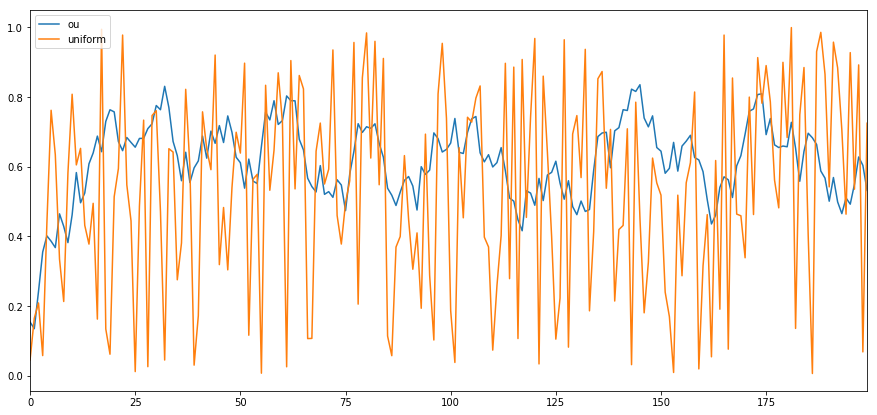

In [ ]:
%matplotlib inline
import pandas as pd


a = OUNoise(1, 10)

data = [(a.sample()[0], random.random()) for _ in range(200)]

df = pd.DataFrame(data, columns=['ou', 'uniform'])
df.plot(figsize=(15, 7))

df.mean()

## Agent

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'


class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, fc1_units=64, fc2_units=64):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed,
                                 fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed,
                                  fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed,
                                   fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed,
                                    fc1_units=fc1_units, fc2_units=fc2_units).to(device)
        
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                           lr=LR_CRITIC,
                                           weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed, theta=NOISE_THETA, sigma=NOISE_SIGMA)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        self.train_counter = 0
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
        self.train_counter += 1

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and (self.train_counter >= UPDATE_EVERY):
            for _ in range(LEARN_ROUNDS):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
            self.train_counter = 0

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
            
        self.actor_local.train()

        if add_noise:
            action += self.noise.sample()
            
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.train_counter = 0

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
torch.cuda.is_available()

True

## Train DDPG on Unity

In [ ]:
def ddpg_unity(env, agent, n_episodes=1000, max_t=100, print_every=10):
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        # start a new episode by resetting the env and getting a fresh observation
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        
        # this will reset the noise process in the DDPG agent
        agent.reset()
        
        score = 0
        for t in range(max_t):
            #print(t, end=' ')
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done:
                break 
                
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
    return scores

## Train a Model

In [ ]:
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # minibatch size
GAMMA = 0.99           # discount factor
TAU = 0.001            # for soft update of target parameters
LR_ACTOR = 0.0001      # learning rate of the actor 
LR_CRITIC = 0.0001     # learning rate of the critic
WEIGHT_DECAY = 0       # L2 weight decay

N_EPS = 5000
MAX_T = 800

UPDATE_EVERY = 20       # num of timesteps to run learning
LEARN_ROUNDS = 10       # repeat learning (sample from memory + backprop) this many times 

LAYER1_NODES=300
LAYER2_NODES=350

NOISE_THETA=0.15
NOISE_SIGMA=0.15

SEED = 13

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

print('Your device:', device)
print('- training starts', time.asctime())

agent = Agent(state_size=state_size,
              action_size=action_size,
              random_seed=SEED,
              fc1_units=LAYER1_NODES,
              fc2_units=LAYER2_NODES)


scores = ddpg_unity(env, agent,
                    n_episodes=N_EPS,
                    max_t=MAX_T,
                    print_every=50)

print('- training end', time.asctime())

Your device: cuda:0
- training starts Fri Mar  8 16:40:55 2019
Episode 49	Average Score: 0.28

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.figure.set_size_inches(12, 5)

plt.plot(np.arange(1, len(scores)+1),
         scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
s = pd.Series(scores)
r = s.rolling(100)

r.mean().dropna().plot(figsize=(12, 5), title='Rolling avg 100eps')

### Attempts

```
===
2.99 score after 500eps with:

BUFFER_SIZE = 25000     # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 0.0005         # learning rate of the actor 
LR_CRITIC = 0.0005        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

N_EPS = 500
MAX_T = 1000

UPDATE_EVERY = 100       # num of timesteps to run learning
LEARN_ROUNDS = 20       # repeat learning (sample from memory + backprop) this many times 

==

5.00 score at eps 200, but training collapses

BUFFER_SIZE = 25000     # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 0.0005         # learning rate of the actor 
LR_CRITIC = 0.0005        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

N_EPS = 500
MAX_T = 1000

UPDATE_EVERY = 50       # num of timesteps to run learning
LEARN_ROUNDS = 20       # repeat learning (sample from memory + backprop) this many times 

===

Increasing the buffer size, training does not collapse

BUFFER_SIZE = 100000     # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 0.0005         # learning rate of the actor 
LR_CRITIC = 0.0005        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

N_EPS = 500
MAX_T = 1000

UPDATE_EVERY = 20       # num of timesteps to run learning
LEARN_ROUNDS = 10       # repeat learning (sample from memory + backprop) this many times 

=== 

score ~9, and steady increase (almost till the end), by lowering LR.

BUFFER_SIZE = 100000     # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 0.0001         # learning rate of the actor 
LR_CRITIC = 0.0001        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

N_EPS = 500
MAX_T = 1000

UPDATE_EVERY = 20       # num of timesteps to run learning
LEARN_ROUNDS = 10       # repeat learning (sample from memory + backprop) this many times 

LAYER1_NODES=128
LAYER2_NODES=256

SEED = 47


===

~29

BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # minibatch size
GAMMA = 0.99           # discount factor
TAU = 0.001            # for soft update of target parameters
LR_ACTOR = 0.0001      # learning rate of the actor 
LR_CRITIC = 0.0001     # learning rate of the critic
WEIGHT_DECAY = 0       # L2 weight decay

N_EPS = 5000
MAX_T = 1000

UPDATE_EVERY = 20       # num of timesteps to run learning
LEARN_ROUNDS = 10       # repeat learning (sample from memory + backprop) this many times 

LAYER1_NODES=300
LAYER2_NODES=300

NOISE_THETA=0.15
NOISE_SIGMA=0.15

SEED = 13
```


### Notes

https://knowledge.udacity.com/questions/22843


In [ ]:
import time

time.asctime()